In [5]:
import os
import json
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tqdm
import cv2
import datetime

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow as tf

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Visualising Dataset

Number of images in training:  5708
Number of images in testing:  1311
Total number of images: 7019


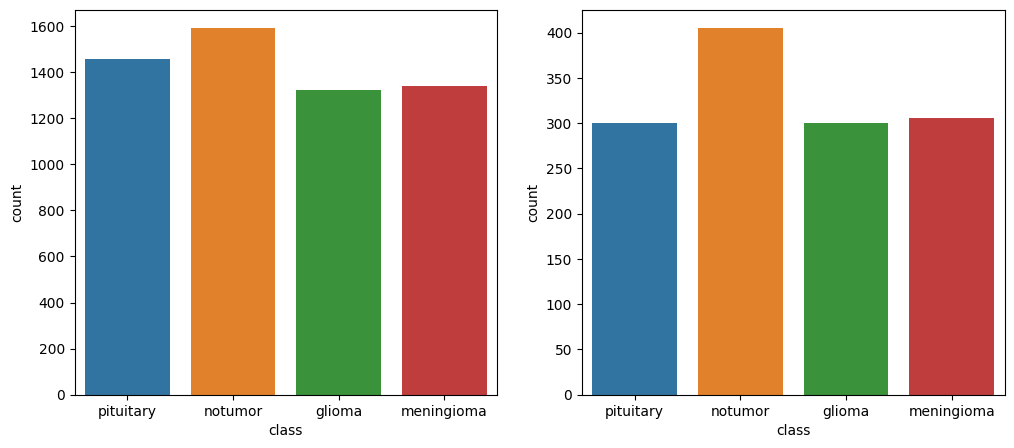

In [2]:
root_path = '/Users/james/MScCode/Final Project/Datasets_cleaned/240_resolution/brain_tumour_large'
labels = []
train_folder = root_path+'/Training/'
test_folder = root_path+'/Testing/'

quantity_tr = {} 
quantity_te = {}
for folder in os.listdir(train_folder):
    if folder != '.DS_Store':
        quantity_tr[folder] = len(os.listdir(train_folder+folder))
        labels.append(folder)
    
for folder in os.listdir(test_folder):
    if folder != '.DS_Store':
        quantity_te[folder] = len(os.listdir(test_folder+folder))
    
    
quantity_train = pd.DataFrame(list(quantity_tr.items()),
                              index=range(0,len(quantity_tr)), columns=['class','count'])

quantity_test = pd.DataFrame(list(quantity_te.items()),
                              index=range(0,len(quantity_te)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(12,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in training: ", sum(quantity_tr.values()))
print("Number of images in testing: ", sum(quantity_te.values()))
print(f'Total number of images: {sum(quantity_tr.values()) + sum(quantity_te.values())}')

plt.show()

# Pre-Processing

In [3]:
def multiclass_preprocessing():
    X_train=[]
    X_test=[]
    y_train=[]
    y_test=[] 
    
    # Training set
    for label in labels:
        folder_dir = f'{train_folder}{label}'
        count = 0
        for file in os.listdir(folder_dir):
            img = cv2.imread(f'{folder_dir}/{file}')
            X_train.append(img)
            y_train.append(label)
                

    # Testing set
    for label in labels:
        folder_dir = f'{test_folder}{label}'
        for file in os.listdir(folder_dir):
            img = cv2.imread(f'{folder_dir}/{file}')
            X_test.append(img)
            y_test.append(label)
            
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    # Rescaling
    X_train=X_train/float(255.0)
    X_test=X_test/float(255.0)
    
    # Shuffling
    X_train_full, y_train_full = shuffle(X_train, y_train, random_state=42)
    X_test, y_test = shuffle(X_test, y_test, random_state=42)
    
    # One-hot encoding y labels
    y_train_full = tf.keras.utils.to_categorical([labels.index(i) for i in y_train_full])
    y_test = tf.keras.utils.to_categorical([labels.index(i) for i in y_test])
    
    # Creating validation datasets (500 length)
    X_train, y_train = X_train_full[:-500], y_train_full[:-500]
    X_val, y_val = X_train_full[-500:], y_train_full[-500:]

    # Shapes
    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
    print(f'X_test shape: {X_test.shape}')
    print(f'y_test shape: {y_test.shape}')
    print(f'X_val shape: {X_val.shape}')
    print(f'y_val shape: {y_val.shape}')
    
    return X_train, y_train, X_test, y_test, X_val, y_val
    
X_train, y_train, X_test, y_test, X_val, y_val = multiclass_preprocessing()

X_train shape: (5208, 240, 240, 3)
y_train shape: (5208, 4)
X_test shape: (1311, 240, 240, 3)
y_test shape: (1311, 4)
X_val shape: (500, 240, 240, 3)
y_val shape: (500, 4)


In [36]:
def plot_results(loss_values, val_loss, loss, accuracy, title):
    """
    Plots evaluation history values of model.
    This plot function was copied from the IMDB lecture notebook.
    """
    print('Test loss:', loss)
    print('Test accuracy:', accuracy)
    
    epochs = range(1, len(loss_values) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.figure(figsize=(10, 6), dpi=100)
    plt.plot(epochs, loss_values, blue_dots, label = 'Training loss')
    plt.plot(epochs, val_loss, solid_blue_line, label = 'Validation loss')
    plt.title(f'Training and validation loss - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show(

# Sequential Model creation

In [65]:
def build_model(num_conv_layers, num_dense_layers, run, save_results=True):
#     t1 = datetime.datetime.now()
#     print(f'Starting Conv: {num_conv_layers} - Dense: {num_dense_layers}')
#     model = Sequential()
    
#     # Convolution and pooling layers 
#     if num_conv_layers == 1:
#         model.add(layers.Conv2D(64, (3, 3), input_shape=(240, 240, 3), activation="relu"))
#         model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        
#     elif num_conv_layers == 2:
#         model.add(layers.Conv2D(64, (3, 3), input_shape=(240, 240, 3), activation="relu"))
#         model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        
#         model.add(layers.Conv2D(64, (3, 3), activation="relu"))
#         model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        
#     elif num_conv_layers == 3:
#         model.add(layers.Conv2D(64, (3, 3), input_shape=(240, 240, 3), activation="relu"))
#         model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        
#         model.add(layers.Conv2D(64, (3, 3), activation="relu"))
#         model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        
#         model.add(layers.Conv2D(128, (3, 3), activation="relu"))
#         model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        
#     elif num_conv_layers == 4:
#         model.add(layers.Conv2D(64, (3, 3), input_shape=(240, 240, 3), activation="relu"))
#         model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        
#         model.add(layers.Conv2D(64, (3, 3), activation="relu"))
#         model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        
#         model.add(layers.Conv2D(128, (3, 3), activation="relu"))
#         model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        
#         model.add(layers.Conv2D(128, (3, 3), activation="relu"))
#         model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        
#     # Flattern the layers
#     model.add(layers.Flatten())
        
#     # Dense and Dropout layers
#     if num_dense_layers == 1:
#         model.add(layers.Dense(4, activation="softmax"))   
        
#     elif num_dense_layers == 2:
#         model.add(layers.Dense(256, activation="relu"))
#         model.add(layers.Dropout(0.2))
#         model.add(layers.Dense(4, activation="softmax"))   
        
#     elif num_dense_layers == 3:
#         model.add(layers.Dense(256, activation="relu"))
#         model.add(layers.Dropout(0.2))
#         model.add(layers.Dense(256, activation="relu"))
#         model.add(layers.Dropout(0.2))
#         model.add(layers.Dense(4, activation="softmax"))  
        
#     elif num_dense_layers == 4:
#         model.add(layers.Dense(256, activation="relu"))
#         model.add(layers.Dropout(0.2))
#         model.add(layers.Dense(256, activation="relu"))
#         model.add(layers.Dropout(0.2))
#         model.add(layers.Dense(256, activation="relu"))
#         model.add(layers.Dropout(0.2))
#         model.add(layers.Dense(4, activation="softmax")) 
        
    
#     model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['acc'])
#     model_history = model.fit(X_train, y_train,
#                   epochs=15,
#                   verbose=1,
#                   validation_data=(X_val, y_val))
    
#     history_dict = model_history.history
#     score = model.evaluate(X_test, y_test, verbose=0)
    
#     print(f'Completed Conv{num_conv_layers} - Dense: {num_dense_layers}')
#     print(f'TTR: {t2-t1}')
    
#     result_dict = [{
#         'run':run,
#         'time': str(t2-t1)
#         'num_conv': num_conv_layers,
#         'num_dense': num_dense_layers,
#         'test_loss':score[0],
#         'test_accuracy':score[1],
#         'loss_values':history_dict['loss'],
#         'val_loss':history_dict['val_loss']
        
#     }]
    
    result_dict = {'hello':'shalom'}
    
    # Saving results
    if save_results == True:
        # If file not exists, create new file
        if os.path.exists("model_creation/model_structure_testing.json") == False:
            with open("model_creation/model_structure_testing.json", "w") as outfile:
                json.dump(result_dict, outfile)
                print('new file made')
        else:
            # Open json file, append new contents
            with open("model_creation/model_structure_testing.json", "r") as infile:
                data = json.load(infile)
                data.extend(result_dict)
                
            # Save extended results
            with open("model_creation/model_structure_testing.json", "w") as outfile:
                json.dump(data, outfile)
                print('updated file')
    
    
build_model(1,1,1)

FileNotFoundError: [Errno 2] No such file or directory: 'model_creation/model_structure_testing.json'

In [62]:
sequential_model = Sequential(
    [
        layers.Conv2D(64, (3, 3), input_shape=(240, 240, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(4, activation="softmax"),    
    ]
)
sequential_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['acc'])

In [63]:
model_history = sequential_model.fit(X_train, y_train,
              epochs=15,
              verbose=1,
              validation_data=(X_val, y_val))

Epoch 1/10


2023-01-26 11:10:46.949553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - ETA: 0s - loss: 0.8242 - acc: 0.6713

2023-01-26 11:11:27.535181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - 43s 259ms/step - loss: 0.8242 - acc: 0.6713 - val_loss: 0.5602 - val_acc: 0.7760
Epoch 2/10
163/163 [==============================] - 41s 250ms/step - loss: 0.4535 - acc: 0.8328 - val_loss: 0.3908 - val_acc: 0.8380
Epoch 3/10
163/163 [==============================] - 40s 247ms/step - loss: 0.2909 - acc: 0.8904 - val_loss: 0.3122 - val_acc: 0.8720
Epoch 4/10
163/163 [==============================] - 40s 246ms/step - loss: 0.1893 - acc: 0.9290 - val_loss: 0.3021 - val_acc: 0.8860
Epoch 5/10
163/163 [==============================] - 41s 249ms/step - loss: 0.1229 - acc: 0.9543 - val_loss: 0.3385 - val_acc: 0.8960
Epoch 6/10
163/163 [==============================] - 42s 255ms/step - loss: 0.0802 - acc: 0.9712 - val_loss: 0.3093 - val_acc: 0.9060
Epoch 7/10
163/163 [==============================] - 39s 238ms/step - loss: 0.0658 - acc: 0.9756 - val_loss: 0.2748 - val_acc: 0.9180
Epoch 8/10
163/163 [==============================] - 39s 238ms/st

In [ ]:
history_dict = model_history.history
score = sequential_model.evaluate(X_test, y_test, verbose=0)
plot_results(history_dict['loss'], history_dict['val_loss'], score[0], score[1], 'Overfitting')